In [1]:
import os
import pandas as pd
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn, optim
from google.colab import drive
from tqdm import tqdm

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device is: {device}\n")

Device is: cuda



In [18]:
data_path = '/content/drive/MyDrive/biomedicine/embedded_data/'

# Hyper- and Controlparameter

In [6]:
# Controlparameter

LOAD_FROM_DRIVE = False
SAVE_TO_DRIVE = False

In [7]:
# HYPERPARAMETER

BATCH_SIZE = 128
LEARNING_RATE = 0.0001
NUM_EPOCHS = 10

# Custom Dataset & Data Preparation

In [8]:
# label_map = {
#     'mild/moderate': 0,
#     'severe/critical': 1,
# }

In [9]:
label_map = {
    'control': 0,
    'mild/moderate': 1,
    'severe/critical': 1,
}

In [57]:
class EmbeddedDataset(Dataset):
    def __init__(self, pkl_file):
        self.data = pd.read_pickle(pkl_file)
        #print(self.data)
        unique_labels = pd.unique(self.data['severity'])
        cell_types = pd.unique(self.data['celltype'])
        print(f"unique cell types: {cell_types}")
        label_counts = {}
        for label in self.data['severity']:
            label_counts[label] = label_counts.get(label, 0) + 1
        print(f"unique labels: {unique_labels}")
        print(f"label counts: {label_counts}")
        print(self.data.head())

    def cell_types_list(self):
        return list(pd.unique(self.data['celltype']))
    def distribution_cell_types(self):
        return self.data['celltype'].value_counts()
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        embeddings = torch.tensor(self.data.iloc[idx, 0], dtype=torch.float32)
        label = torch.tensor(label_map.get(self.data.iloc[idx, 1]), dtype=torch.float32)
        cell_type = self.data.iloc[idx, 2]
        return embeddings, label, cell_type

In [58]:
dataset = EmbeddedDataset(os.path.join(data_path, 'embedded_data_split_severity_celltype_0_5.pkl'))

unique cell types: ['T_CD8_c06-TNF' 'T_CD4_c04-ANXA2' 'T_CD8_c05-ZNF683' 'T_CD4_c01-LEF1'
 'B_c01-TCL1A' 'T_CD4_c05-FOS' 'T_CD4_c06-NR4A2' 'NK_c01-FCGR3A'
 'T_CD8_c07-TYROBP' 'T_CD4_c11-GNLY' 'Mono_c3-CD14-VCAN' 'T_CD8_c04-COTL1'
 'B_c03-CD27-AIM2' 'T_CD4_c08-GZMK-FOS_h' 'Mono_c1-CD14-CCL3'
 'T_CD4_c09-GZMK-FOS_l' 'T_CD8_c08-IL2RB' 'Mono_c2-CD14-HLA-DPB1'
 'T_CD8_c09-SLC4A10' 'DC_c4-LILRA4' 'T_CD4_c02-AQP3' 'T_CD8_c03-GZMK'
 'T_CD4_c07-AHNAK' 'T_CD8_c02-GPR183' 'B_c02-MS4A1-CD27' 'T_CD8_c01-LEF1'
 'T_CD4_c03-ITGA4' 'Mono_c4-CD14-CD16' 'T_CD8_c12-MKI67-TYROBP'
 'T_CD4_c12-FOXP3' 'Macro_c2-CCL3L1' 'B_c06-MKI67' 'DC_c2-CD1C'
 'T_CD8_c10-MKI67-GZMK' 'Mono_c5-CD16' 'Mega' 'NK_c03-MKI67'
 'B_c04-SOX5-TNFRSF1B' 'T_gdT_c14-TRDV2' 'B_c05-MZB1-XBP1'
 'T_CD4_c14-MKI67-CCL5_h' 'NK_c02-NCAM1' 'T_CD8_c13-HAVCR2'
 'T_CD4_c13-MKI67-CCL5_l' 'Macro_c5-WDR74' 'Neu_c2-CXCR4(low)'
 'Neu_c1-IL1B' 'T_CD4_c10-IFNG' 'T_CD8_c11-MKI67-FOS' 'DC_c1-CLEC9A'
 'Macro_c1-C1QC' 'Macro_c4-DNAJB1' 'Neu_c5-GSTP1(high)OASL

In [59]:
dataset.distribution_cell_types()

,count
celltype,
Mono_c3-CD14-VCAN,32185
B_c01-TCL1A,23579
Mono_c2-CD14-HLA-DPB1,21658
T_CD4_c01-LEF1,20967
T_CD8_c01-LEF1,16036
T_CD8_c05-ZNF683,14809
T_CD8_c07-TYROBP,14593
NK_c01-FCGR3A,13348
Mono_c1-CD14-CCL3,11448


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [28]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [29]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [31]:
for (embeddings, labels,_) in train_loader:
    print(type(embeddings[0]))
    print(type(labels[0]))
    print(type(embeddings[0][0]))
    print(type(labels[0].item()))
    break

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'float'>


# Model Architecture


In [32]:
class Classifier(torch.nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_features=512, out_features=1024),
            nn.LeakyReLU(0.2),
            nn.Linear(in_features=1024, out_features=2048),
            nn.LeakyReLU(0.2),
            nn.Linear(in_features=2048, out_features=2048),
            nn.LeakyReLU(0.2),
            nn.Linear(in_features=2048, out_features=1024),
            nn.LeakyReLU(0.2),
            nn.Linear(in_features=1024, out_features=1024),
            nn.LeakyReLU(0.2),
            nn.Linear(in_features=1024, out_features=1),
            nn.LeakyReLU(0.2),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x).squeeze()

In [33]:
# trainings loop

def train(model, train_loader, num_epocs, optimizer, criterion):
    for epoch in range(num_epocs):
        model.to(device).train()
        running_loss = 0.0
        dataloader = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epocs}")
        for i, (embeddings, label, _) in enumerate(dataloader):
            embeddings, label = embeddings.to(device), label.to(device)
            optimizer.zero_grad()
            output = model(embeddings)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            dataloader.set_postfix({"loss":running_loss/(i+1)})

In [ ]:
# directory paths to google drive for model saving and retrieving

directory_path = 'content/MyDrive/biomedicine/models/classifier'

binary_classifier_model_path = os.path.join(directory_path, 'binary_classifier.pth')

In [34]:
# custom weights initialization
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 1/m.weight.shape[1])

In [35]:
# Initialize the model

classifier_model = Classifier().to(device)

if LOAD_FROM_DRIVE:
    try:
        classifier_model.load_state_dict(torch.load(binary_classifier_model_path, weights_only=True))
        print("Model loaded from drive")
    except Exception as e:
        print(f"Error loading model from drive: {e}")
# else:
#     classifier_model.apply(weights_init)

# set up loss function and optimizer

criterion = nn.BCELoss()
optimizer = optim.Adam(classifier_model.parameters(), lr=LEARNING_RATE)

# Training

In [36]:
# start training loop
if not LOAD_FROM_DRIVE:
    train(
        model=classifier_model,
        train_loader=train_loader,
        num_epocs=NUM_EPOCHS,
        optimizer=optimizer,
        criterion=criterion
    )

Epoch 10/10: 100%|██████████| 1829/1829 [00:39<00:00, 45.95it/s, loss=0.0947]


In [ ]:
# save to drive

if SAVE_TO_DRIVE:
    try:
        os.makedirs(directory_path)
    except FileExistsError:
        pass

    torch.save(classifier_model.state_dict(), binary_classifier_model_path)
    print("Model saved to drive")

# Evaluation

In [86]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from collections import defaultdict

def evaluate(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    cell_type_results = defaultdict(lambda: {"y_true": [], "y_pred": []})  # Store results per cell type

    with torch.no_grad():
        for embeddings, labels, cell_types in test_loader:
            embeddings, labels = embeddings.to(device), labels.to(device)
            outputs = model(embeddings).squeeze()
            preds = (outputs >= 0.5).long()  # Convert probabilities to 0 or 1

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Store results for each cell type
            for i, cell in enumerate(cell_types):
                cell_type_results[cell]["y_true"].append(labels[i].item())
                cell_type_results[cell]["y_pred"].append(preds[i].item())

    # Compute overall metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)

   # print(f"Overall Results:")
   # print(f"  Accuracy:  {accuracy:.4f}")
   # print(f"  Precision: {precision:.4f}")
   # print(f"  Recall:    {recall:.4f}")
    #print(f"  F1-score:  {f1:.4f}")

    # Compute metrics per cell type
    #print("\nResults by Cell Type:")
    best_cell = None
    best_f1 = 0
    cell_type_list, acc_list, f1_list, prec_list, rec_list = [], [], [], [], []
    for cell, values in cell_type_results.items():
        acc = accuracy_score(values["y_true"], values["y_pred"])
        prec = precision_score(values["y_true"], values["y_pred"], zero_division=0)
        rec = recall_score(values["y_true"], values["y_pred"], zero_division=0)
        f1 = f1_score(values["y_true"], values["y_pred"], zero_division=0)
        cell_type_list.append(cell)
        acc_list.append(acc)
        f1_list.append(f1)
        prec_list.append(prec)
        rec_list.append(rec)
    cell_type_results_df = pd.DataFrame({
        "Cell Type": cell_type_list,
        "Accuracy": acc_list,
        "F1-score": f1_list,
        "Precision": prec_list,
        "Recall": rec_list
    })
      #  print(f"  {cell}: Accuracy={acc:.4f}, Precision={prec:.4f}, Recall={rec:.4f}, F1-score={f1:.4f}")



    #print(f"\nBest Cell Type: {best_cell} (F1-score={best_f1:.4f})")

    return accuracy, precision, recall, f1, best_cell, cell_type_results_df


In [87]:
import pandas as pd
from collections import Counter

def compare_cell_type_distribution(dataset, train_loader, test_loader):
    # Get total distribution from dataset (assuming it's a DataFrame)
    total_distribution = dataset.distribution_cell_types()

    # Ensure it's a DataFrame
    if isinstance(total_distribution, pd.Series):
        total_distribution = total_distribution.reset_index()
        total_distribution.columns = ["Cell Type", "Total Count"]

    # Initialize counters for train and test sets
    train_counter = Counter()
    test_counter = Counter()

    # Count occurrences of each cell type in training set
    for _, _, cell_types in train_loader:
        train_counter.update(cell_types)

    # Count occurrences of each cell type in test set
    for _, _, cell_types in test_loader:
        test_counter.update(cell_types)

    # Convert counters to Pandas Series
    train_series = pd.Series(train_counter, name="Train Count")
    test_series = pd.Series(test_counter, name="Test Count")

    # Create a DataFrame with all distributions
    df = total_distribution.set_index("Cell Type").join([train_series, test_series]).fillna(0)

    # Convert counts to integers
    df = df.astype(int)

    # Print the table
   # print(df)

    return df


In [95]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

def analyze_correlation(dataset, train_loader, test_loader, model):
    # Step 1: Get dataset distribution
    total_distribution = dataset.distribution_cell_types()

    # Ensure it's a DataFrame
    if isinstance(total_distribution, pd.Series):
        total_distribution = total_distribution.reset_index()
        total_distribution.columns = ["Cell Type", "Train Count"]

    # Step 2: Evaluate model performance per cell type
    _, _, _, _, _, cell_results = evaluate(model, test_loader)
    """
    # Step 3: Ensure cell_results is properly structured
    if isinstance(cell_results, dict):
        performance_data = []
        for cell_type, metrics in cell_results.items():
            if isinstance(metrics, dict):  # Ensure it's not a string or number
                row = {"Cell Type": cell_type}
                row.update(metrics)  # Add accuracy, F1-score, etc.
                performance_data.append(row)
        performance_df = pd.DataFrame(performance_data)
    else:
        raise ValueError("cell_results is not a valid dictionary.")
    """
    # Step 4: Merge both DataFrames
    merged_df = total_distribution.merge(cell_results, on="Cell Type", how="inner")

    # Step 5: Compute correlation
    correlation_results = {
        "Accuracy": pearsonr(merged_df["Train Count"], merged_df["Accuracy"])[0],
        "F1-score": pearsonr(merged_df["Train Count"], merged_df["F1-score"])[0]
    }

    # Step 6: Visualization
    plt.figure(figsize=(12, 5))

    # Scatter Plot: Frequency vs Accuracy
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=merged_df["Train Count"], y=merged_df["Accuracy"])
    plt.xlabel("Train Count of Cell Type")
    plt.ylabel("Accuracy")
    plt.title(f"Correlation: {correlation_results['Accuracy']:.4f}")

    # Scatter Plot: Frequency vs F1-score
    plt.subplot(1, 2, 2)
    sns.scatterplot(x=merged_df["Train Count"], y=merged_df["F1-score"])
    plt.xlabel("Train Count of Cell Type")
    plt.ylabel("F1-score")
    plt.title(f"Correlation: {correlation_results['F1-score']:.4f}")

    plt.tight_layout()
    plt.show()

    # Print correlation results
    print("Correlation between Cell Type Frequency and Performance:")
    print(f"  Accuracy Correlation: {correlation_results['Accuracy']:.4f}")
    print(f"  F1-score Correlation: {correlation_results['F1-score']:.4f}")

    return merged_df, correlation_results


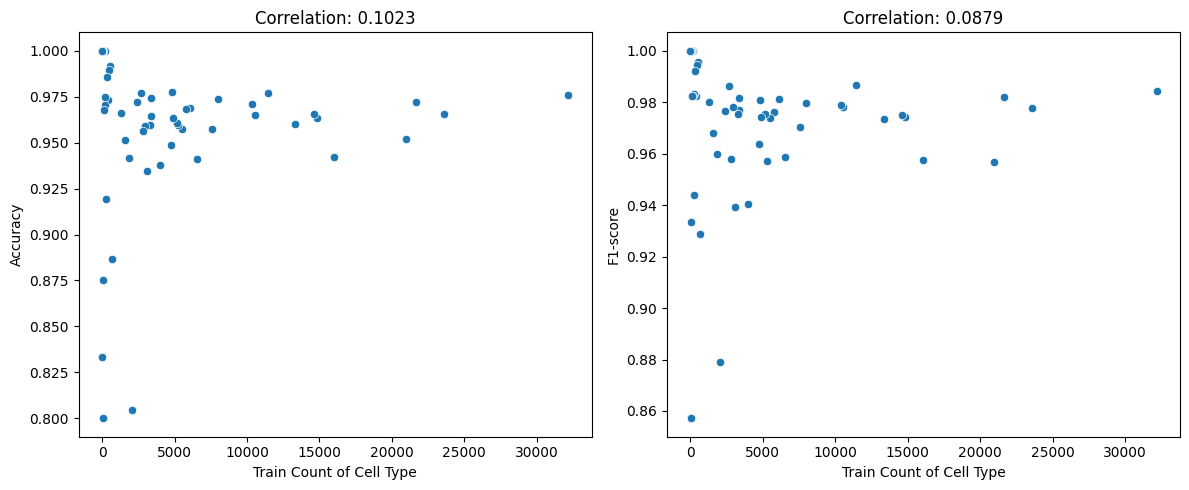

Correlation between Cell Type Frequency and Performance:
  Accuracy Correlation: 0.1023
  F1-score Correlation: 0.0879


In [96]:
df_analysis, correlation = analyze_correlation(dataset, train_loader, test_loader, classifier_model)

In [65]:
compare_cell_type_distribution(dataset, train_loader, test_loader)


                             Total Count  Train Count  Test Count
Cell Type                                                        
Mono_c3-CD14-VCAN                  32185        25773        6412
B_c01-TCL1A                        23579        18953        4626
Mono_c2-CD14-HLA-DPB1              21658        17300        4358
T_CD4_c01-LEF1                     20967        16842        4125
T_CD8_c01-LEF1                     16036        12813        3223
T_CD8_c05-ZNF683                   14809        11843        2966
T_CD8_c07-TYROBP                   14593        11670        2923
NK_c01-FCGR3A                      13348        10599        2749
Mono_c1-CD14-CCL3                  11448         9142        2306
B_c02-MS4A1-CD27                   10568         8441        2127
T_CD8_c03-GZMK                     10380         8256        2124
T_CD8_c08-IL2RB                     8005         6419        1586
Mono_c5-CD16                        7582         6024        1558
B_c03-CD27

,Total Count,Train Count,Test Count
Cell Type,,,
Mono_c3-CD14-VCAN,32185,25773,6412
B_c01-TCL1A,23579,18953,4626
Mono_c2-CD14-HLA-DPB1,21658,17300,4358
T_CD4_c01-LEF1,20967,16842,4125
T_CD8_c01-LEF1,16036,12813,3223
T_CD8_c05-ZNF683,14809,11843,2966
T_CD8_c07-TYROBP,14593,11670,2923
NK_c01-FCGR3A,13348,10599,2749
Mono_c1-CD14-CCL3,11448,9142,2306


In [52]:
evaluate(classifier_model, test_loader)

Overall Results:
  Accuracy:  0.9621
  Precision: 0.9743
  Recall:    0.9734
  F1-score:  0.9738

Results by Cell Type:
  T_CD8_c07-TYROBP: Accuracy=0.9658, Precision=0.9713, Recall=0.9790, F1-score=0.9751
  NK_c01-FCGR3A: Accuracy=0.9603, Precision=0.9718, Recall=0.9751, F1-score=0.9734
  B_c01-TCL1A: Accuracy=0.9654, Precision=0.9742, Recall=0.9812, F1-score=0.9777
  T_CD4_c12-FOXP3: Accuracy=0.9344, Precision=0.9307, Recall=0.9479, F1-score=0.9392
  Mono_c2-CD14-HLA-DPB1: Accuracy=0.9720, Precision=0.9793, Recall=0.9850, F1-score=0.9822
  T_CD8_c04-COTL1: Accuracy=0.9636, Precision=0.9608, Recall=0.9880, F1-score=0.9742
  Mono_c3-CD14-VCAN: Accuracy=0.9758, Precision=0.9844, Recall=0.9842, F1-score=0.9843
  T_CD4_c11-GNLY: Accuracy=0.9745, Precision=0.9855, Recall=0.9774, F1-score=0.9814
  T_gdT_c14-TRDV2: Accuracy=0.9775, Precision=0.9783, Recall=0.9836, F1-score=0.9810
  T_CD4_c01-LEF1: Accuracy=0.9518, Precision=0.9821, Recall=0.9325, F1-score=0.9567
  T_CD8_c08-IL2RB: Accuracy=0

(0.9621077459492718,
 0.9742547105132509,
 0.973357267702773,
 1.0,
 'Macro_c2-CCL3L1')

## Evaluation in detail: